<font size = 7>DELE ST1504 CA2 Part B: Reinforcement Learning </font>
<hr>
<font size = 4>
Name: Lee Hong Yi & Yadanar Aung<br>
Admin No: 2223010 & 2214621<br>
Class: DAAA/FT/2B/07<br>
</font>
<hr>

**Objective:**  
Develop a model using a <U>modified Deep Q-Network (DQN)</U> architecture to <u>balance a pendulum</u>. The model should apply <u>suitable torque</u> to maintain the pendulum in an <u>upright position</u>. The primary focus is on demonstrating the effectiveness of the DQN in this context, with the possibility of exploring other reinforcement learning architectures after the successful implementation of DQN.

**Background:**  
Deep Q-Networks are a class of deep reinforcement learning algorithms that <u>combine Q-Learning with deep neural networks</u>. This project aims to apply DQN to the classic control problem of pendulum balancing, a benchmark challenge in the reinforcement learning field. The goal is to train a model that can learn the optimal strategy to keep the pendulum balanced by applying the correct amount of torque.

**Key Features:** <br>
Implement a modified version of the DQN algorithm to specifically address the dynamics of pendulum balancing, using the <u>Pendulum environment from OpenAI Gym</u>, which provides a standardized platform for testing the model's performance.

**Output Specification:**  
The output specification for this Deep Q-Network (DQN) project focused on balancing a pendulum entails the generation of <u>control actions</u> in the form of torque values, which are applied at each timestep to maintain the pendulum's upright position. These actions, derived from the model's learning process, will be complemented by performance metrics demonstrating the learning progression, such as episode duration, balance efficiency, and torque magnitude. Additionally, the model will provide visualizations of the pendulum's state and behavior over time, as well as detailed evaluation metrics like <u>average reward per episode</u> and <u>loss over time</u>. The final output includes the <u>learned policy</u>, represented either through model weights or a graphical depiction, showcasing the model's effectiveness in learning and applying the optimal strategy for pendulum balance.

<hr>
<font size = 5>Performing initial set-up</font>
<hr>

In [26]:
%load_ext autoreload
%autoreload 1
%aimport rlfunction

import gc
import gym
import time
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython import display as ipythondisplay
from IPython.display import HTML
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import rlfunction as rlf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from warnings import simplefilter
simplefilter(action='ignore', category=UserWarning)     
simplefilter(action='ignore', category=FutureWarning) 
simplefilter(action='ignore', category=DeprecationWarning)

sns.set_style()
sns.set_style('darkgrid')

In [28]:
# Fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(0)  

In [29]:
# Check GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')

# Memory control: Prevent tensorflow from allocating totality of GPU memory
for gpu in gpus:
    try:
        print(tf.config.experimental.get_device_details(gpu))
    except:
        pass
    tf.config.experimental.set_memory_growth(gpu, True)
print(f"There are {len(gpus)} GPU(s) present.")

{'device_name': 'NVIDIA GeForce RTX 3060', 'compute_capability': (8, 6)}
There are 1 GPU(s) present.


<hr>
<font size = 5>Background Research</font>
<hr>

We will be working with the <u>Pendulum environment</u> from OpenAI Gym. 

A pendulum is attached at one end to a fixed point, with the other end free. The pendulum starts in any random position. The goal is to apply torque on the free end to swing it into an upright position, with its center of gravity right above the fixed point.

<img src='https://www.gymlibrary.dev/_images/pendulum.gif' width=300 height=300> 
<br><br>

<table>
  <tr>
    <td>Action Space</td>
    <td>Box(-2.0, 2.0, (1,), float32)</td>
  </tr>
  <tr>
    <td>Observation Shape</td>
    <td>(3,)</td>
  </tr>
  <tr>
    <td>Observation High</td>
    <td>[1. 1. 8.]</td>
  </tr>
  <tr>
    <td>Observation Low</td>
    <td>[-1. -1. -8.]</td>
  </tr>
</table>

<br>

The figure below specifies the coordinate system used for the implementation of the pendulum's dynamic equations.

<img src='https://gymnasium.farama.org/_images/pendulum.png'> 

- `x-y`: Cartesian coordinates of the pendulum’s end in meters.
- `theta`: Angle in radians.
- `tau`: Torque in N m. Defined as positive <i>counter-clockwise</i>.

<br>

The <b>Action space</b> is continuous, with an infinite number of actions. The action is ndarray with shape (1,), which represents the torque applied to the free end of the pendulum.
<table>
  <tr>
    <th>Num</th>
    <th>Action</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>Torque</td>
    <td>-2.0</td>
    <td>2.0</td>
  </tr>
</table>

<br>

The <b>Observation space</b> is continuous. The observation is a ndarray with shape (3,), which represents the x-y coordinates of the pendulum's free end and its angular velocity.
<table>
  <tr>
    <th>Num</th>
    <th>Observation</th>
    <th>Min</th>
    <th>Max</th>
  </tr>
  <tr>
    <td>0</td>
    <td>x = cos(theta)</td>
    <td>-1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>1</td>
    <td>y = sin(angle)</td>
    <td>-1.0</td>
    <td>1.0</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Angular Velocity</td>
    <td>-8.0</td>
    <td>8.0</td>
  </tr>
</table>

<br>

The <b>Reward</b> function is defined as: <i>r = -(theta^2 + 0.1 * theta_dt^2 + 0.001 * torque^2)</i>
- Where `theta` is the pendulum’s angle normalized between [-pi, pi] (with 0 being in the upright position)
- Min reward: -(pi^2 + 0.1 * 8^2 + 0.001 * 2^2) = -16.2736044
- Max reward: 0 (pendulum is upright with zero velocity and no torque applied)

The <b>Starting State</b> is a random angle in <i>[-pi, pi]</i> and a random angular velocity in <i>[-1,1]</i>.

The <b>Episode Truncates</b> at 200 time steps.

Source: https://www.gymlibrary.dev/environments/classic_control/pendulum/

<h3>Create Environment</h3>

In [30]:
# Initialize the environment with specified render mode
env = gym.make('Pendulum-v1', render_mode='rgb_array')

# Set the environment to the initial state
env.reset()
frames = []
reward_arr = []

# Run the simulation for 50 time steps
for _ in range(50):
    # Take a random action
    action = env.action_space.sample()
    _, reward, _, *_ = env.step(action)
    reward_arr.append(reward)
    frame = env.render()
    frames.append(frame)

# Close the environment
env.close()

ani = rlf.create_animation(frames)
print(f"Reward for test episode (random): {np.mean(reward_arr)}")
HTML(ani.to_jshtml())
# display(ani)

Reward for test episode (random): -7.867160083525732


<hr>
<font size = 5>Exploratory Data Analysis (EDA)</font>
<hr>

<hr>
<font size = 5>Feature Engineering</font>
<hr>

<hr>
<font size = 5>Initial Modelling</font>
<hr>

saw said can use the code from lab 6, but there is something to fix so that it works for ca2.

dqn onyl good for discrete space. discretisize this env for dqn to work (put bins, e.g. 2 / 10 bins e.g. -1 to -1.6 is a bin)

no. of bins = no.s of actions

i lazy to do proper markdown 


note: markdown should mention how/when the reward comes into play, like via the loss fucntion etc. (bellman equation??)

In [31]:
# Discretize the action space
state_size = env.observation_space.shape[0]
num_discrete_actions =  10
action_bounds = env.action_space.high[0]  # Assuming symmetric bounds
discrete_actions = np.linspace(-action_bounds, action_bounds, num_discrete_actions)

In [37]:
class dqn_template:
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=1000, batch_size=64):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.train_start = 1000
        self.memory = deque(maxlen = memory_size)
        self.reward_arr = []
        self.model = self.model_init(state_size, action_size)

    def model_init(self, state_size, action_size):
        pass
    
    def prepare_training_data(self):
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state[0] for state, _, _, _, _ in minibatch])
        targets = np.zeros((self.batch_size, num_discrete_actions))

        for i, (state, action_index, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose = 0)[0])
            target_f = self.model.predict(state, verbose = 0)[0]
            target_f[action_index] = target
            targets[i] = target_f

        return states, targets
    
    def train(self, train_length = 100):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        for episode in range(train_length + 1):
            avg_score = []
            initial_state = env.reset()
            if isinstance(initial_state, tuple):
                state = initial_state[0]
            else:
                state = initial_state
            state = np.reshape(state, [1, self.state_size])
            for step in range(200):
                if np.random.rand() <= self.epsilon:
                    action_index = random.randrange(self.action_size)
                else:
                    action_index = np.argmax(self.model.predict(state, verbose=0)[0])
                next_state, reward, _, done, _ = env.step([discrete_actions[action_index]])
                next_state = np.reshape(next_state, [1, self.state_size])
                self.memory.append((state, action_index, reward, next_state, done))
                state = next_state
                avg_score.append(reward)
                if len(self.memory) > self.train_start:
                    states, targets = self.prepare_training_data()
                    with tf.GradientTape() as tape:
                        predictions = self.model(states)
                        loss = tf.keras.losses.MSE(targets, predictions)
                    gradients = tape.gradient(loss, self.model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                if done:
                    break
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            print(f"Episode {episode + 1}: Average Reward: {np.mean(avg_score):.6f}, Epsilon: {self.epsilon:.6f}")
            self.reward_arr.append(np.mean(avg_score))
            gc.collect()

        return self.reward_arr

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 24)                96        
                                                                 
 dense_72 (Dense)            (None, 48)                1200      
                                                                 
 dense_73 (Dense)            (None, 48)                2352      
                                                                 
 dense_74 (Dense)            (None, 10)                490       
                                                                 
Total params: 4,138
Trainable params: 4,138
Non-trainable params: 0
_________________________________________________________________
Episode 1: Average Reward: -7.996499, Epsilon: 0.995000


Episode 2: Average Reward: -6.638843, Epsilon: 0.990025
Episode 3: Average Reward: -3.734057, Epsilon: 0.985075
Episode 4: Average Reward: -5.714318, Epsilon: 0.980150
Episode 5: Average Reward: -5.208504, Epsilon: 0.975249
Episode 6: Average Reward: -5.849590, Epsilon: 0.970373
Episode 7: Average Reward: -8.444776, Epsilon: 0.965521
Episode 8: Average Reward: -8.013563, Epsilon: 0.960693
Episode 9: Average Reward: -7.859017, Epsilon: 0.955890
Episode 10: Average Reward: -7.852634, Epsilon: 0.951110
Episode 11: Average Reward: -5.778489, Epsilon: 0.946355
Episode 12: Average Reward: -5.741591, Epsilon: 0.941623
Episode 13: Average Reward: -6.663577, Epsilon: 0.936915
Episode 14: Average Reward: -6.473738, Epsilon: 0.932230
Episode 15: Average Reward: -4.436745, Epsilon: 0.927569
Episode 16: Average Reward: -4.847634, Epsilon: 0.922931
Episode 17: Average Reward: -3.919527, Epsilon: 0.918316
Episode 18: Average Reward: -7.805810, Epsilon: 0.913725
Episode 19: Average Reward: -6.710187, 

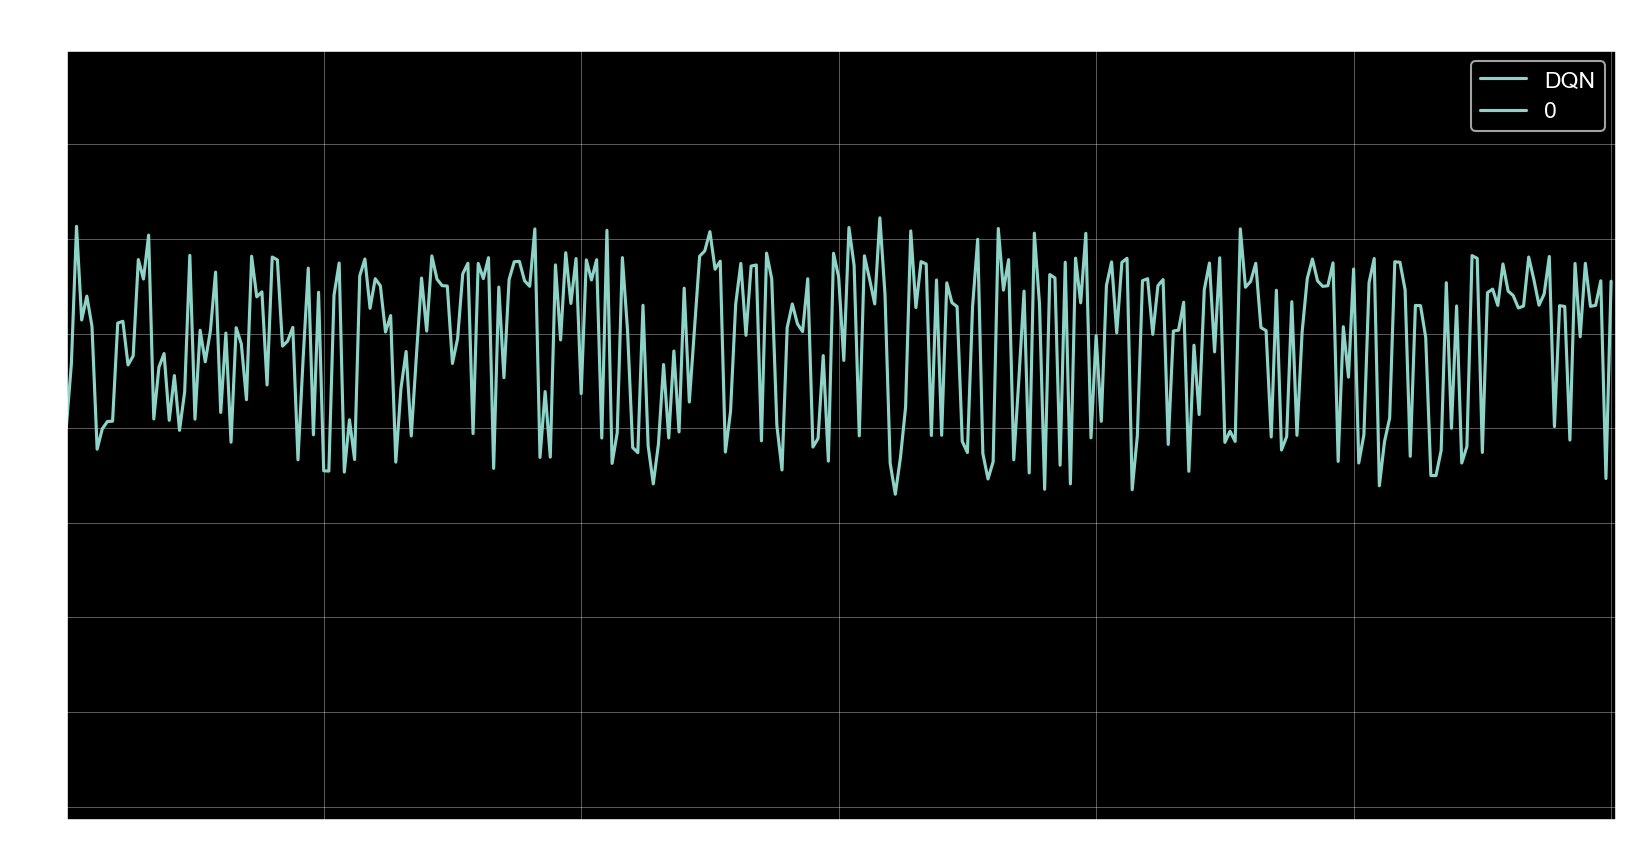

Average reward for test episode: -4.910926924086931


In [38]:
class dqn(dqn_template):
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=1000, batch_size=64):
        super().__init__(state_size, action_size, learning_rate, gamma, epsilon, epsilon_min, epsilon_decay, memory_size, batch_size)
    
    def model_init(self, state_size, action_size):        
        model = Sequential()
        model.add(Dense(24, input_dim=state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model
        

dqn_agent = dqn(state_size, num_discrete_actions, epsilon_decay = 0.995, epsilon_min=0.02)
dqn_reward_arr = dqn_agent.train(train_length = 300)
rlf.plot_results([dqn_reward_arr], ['DQN'], "DQN")
rlf.env_viz(dqn_agent, state_size=state_size, discrete_actions=discrete_actions)

For this, we shall use more complicated models such as `Double DQN`, `Duelling DQN`, and `Rainbow`

<hr>
<font size = 5>Double DQN</font>
<hr>

In [39]:
class double_dqn(dqn_template):
    def __init__(self, state_size, action_size, learning_rate=0.001, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, memory_size=1000, batch_size=64, update_target_every=10):
        super().__init__(state_size, action_size, learning_rate, gamma, epsilon, epsilon_min, epsilon_decay, memory_size, batch_size)
        self.target_model = self.model_init(state_size, action_size)
        self.update_target_every = update_target_every
        self.align_target_model()

    def align_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def prepare_training_data(self):
        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state[0] for state, _, _, _, _ in minibatch])
        targets = np.zeros((self.batch_size, self.action_size))

        for i, (state, action_index, reward, next_state, done) in enumerate(minibatch):
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)[0]
            target_f[action_index] = target
            targets[i] = target_f

        return states, targets
    
    def model_init(self, state_size, action_size):        
        model = Sequential()
        model.add(Dense(24, input_dim=state_size, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary()
        return model
        

    def train(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        for episode in range(100):
            avg_score = []
            initial_state = env.reset()
            if isinstance(initial_state, tuple):
                state = initial_state[0]
            else:
                state = initial_state
            state = np.reshape(state, [1, self.state_size])
            for step in range(200):
                if np.random.rand() <= self.epsilon:
                    action_index = random.randrange(self.action_size)
                else:
                    action_index =  np.argmax(self.model.predict(state, verbose=0)[0])
                next_state, reward, _, done, _ = env.step([discrete_actions[action_index]])
                next_state = np.reshape(next_state, [1, self.state_size])
                self.memory.append((state, action_index, reward, next_state, done))
                state = next_state
                avg_score.append(reward)
                if len(self.memory) > self.train_start:
                    states, targets = self.prepare_training_data()
                    with tf.GradientTape() as tape:
                        predictions = self.model(states)
                        loss = tf.keras.losses.MSE(targets, predictions)
                    gradients = tape.gradient(loss, self.model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
                if done:
                    break
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            if episode % self.update_target_every == 0:
                self.align_target_model()

            print(f"Episode {episode + 1}: Average Reward: {np.mean(avg_score):.6f}, Epsilon: {self.epsilon:.6f}")
            self.reward_arr.append(np.mean(avg_score))
            gc.collect()

        return self.reward_arr
    
ddqn_agent = double_dqn(state_size, num_discrete_actions, epsilon_decay = 0.99995, epsilon_min=0.02)
ddqn_reward_arr = ddqn_agent.train(train_length = 300)
rlf.plot_results([ddqn_reward_arr], ['DDQN'], "Double DQN")
rlf.env_viz(ddqn_agent, state_size=state_size, discrete_actions=discrete_actions)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 24)                96        
                                                                 
 dense_76 (Dense)            (None, 48)                1200      
                                                                 
 dense_77 (Dense)            (None, 48)                2352      
                                                                 
 dense_78 (Dense)            (None, 10)                490       
                                                                 
Total params: 4,138
Trainable params: 4,138
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_79 (Dense)            (None, 24)                96        
                                                                 
 dense_80 (Dense)            (None, 48)                1200      
                                                                 
 dense_81 (Dense)            (None, 48)                2352      
                                                                 
 dense_82 (Dense)            (None, 10)                490       
                                                                 
Total params: 4,138
Trainable params: 4,138
Non-trainable params: 0
_________________________________________________________________


TypeError: train() got an unexpected keyword argument 'train_length'

<hr>
<font size = 5>Model Improvement</font>
<hr>

<hr>
<font size = 5>Conclusion</font>
<hr>